In [10]:
from gzip import compress as _gzip_compress
from itertools import chain
from functools import lru_cache
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count

import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
digits = datasets.load_digits()

In [3]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

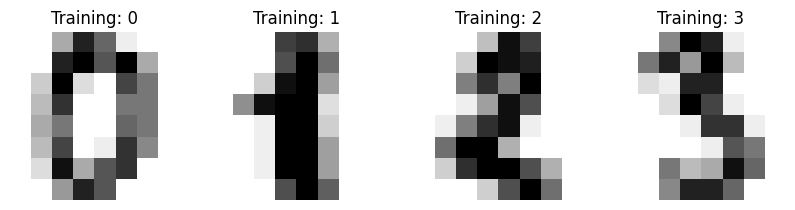

In [11]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [4]:
# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.3, shuffle=True)

In [5]:
@lru_cache(maxsize=2048)
def gzip_compress(x):
    return len(_gzip_compress(x))

def NCD(xs):
    x1, x2 = xs
    Cx1 = gzip_compress(x1.tobytes())
    Cx2 = gzip_compress(x2.tobytes())
    Cx1x2 = gzip_compress(((x1 + x2).tobytes()))
    val = round((Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2), 6)
    return val if val > 0 else 0

In [6]:
def optimized_train_matrix(lst):
    flat_list = list(chain.from_iterable(lst))
    n = int(np.sqrt(len(flat_list) * 2))
    matrix = np.zeros((n, n))
    matrix[np.tril_indices_from(matrix, k=0)] = flat_list
    matrix += matrix.T
    matrix[np.diag_indices_from(matrix)] /= 2
    return matrix

def calculate(data):
    i, x1 = data
    return [NCD((x1, x2)) for x2 in X_train[:(i+2)-1]]

def train(X_train):
    with ProcessPoolExecutor(max_workers=cpu_count()) as executor:
        return optimized_train_matrix(executor.map(calculate, enumerate(X_train), chunksize=30))

def infer(X_test, X_train):
    with ProcessPoolExecutor(max_workers=cpu_count()) as executor:
        X_test_distance = list(executor.map(NCD, ((x1, x2) for x1 in X_test for x2 in X_train), chunksize=30))
        return np.array(X_test_distance).reshape(-1, len(X_train))

X_distance = train(X_train)
X_test_distance = infer(X_test, X_train)

In [7]:
neigh = KNeighborsClassifier(n_neighbors=5, metric="precomputed")
neigh.fit(X_distance, y_train)
print(f"{round(neigh.score(X_test_distance, y_test) * 100, 2)}%")

80.0%


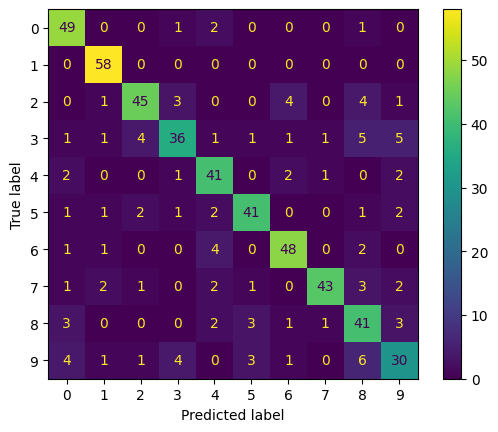

In [9]:
cmd = ConfusionMatrixDisplay(
    confusion_matrix(y_test, neigh.predict(X_test_distance)),
    display_labels=[str(i) for i in range(10)]
)
cmd.plot()